# Smart Inventory Business Analytics


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from database.dao.db_config import DB_CONFIG

user = DB_CONFIG['USER']
password = DB_CONFIG['PASSWORD']
host = DB_CONFIG['HOST']
port = DB_CONFIG.get('PORT')
db_name = DB_CONFIG['NAME']

connection_string = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db_name}"
engine = create_engine(connection_string)

print(f"Connected to Database: {db_name}")


Connected to Database: smart_inventory_db


### Data export from database to CSV

In [2]:
with engine.connect() as conn:
    df_products = pd.read_sql("SELECT * FROM products", conn)
    df_customers = pd.read_sql("SELECT * FROM customers", conn)
    df_orders = pd.read_sql("SELECT * FROM orders", conn)
    df_items = pd.read_sql("SELECT * FROM order_items", conn)

df_products.to_csv('products.csv', index=False)
df_customers.to_csv('customers.csv', index=False)
df_orders.to_csv('orders.csv', index=False)
df_items.to_csv('order_items.csv', index=False)
print("Step 1 Complete: Data exported to CSV files!")

Step 1 Complete: Data exported to CSV files!


### Load Data from CSV

In [3]:
df_products = pd.read_csv('products.csv')
df_customers = pd.read_csv('customers.csv')
df_orders = pd.read_csv('orders.csv')
df_items = pd.read_csv('order_items.csv')

print("Step 2 Complete: CSV loaded into DataFrames!")

Step 2 Complete: CSV loaded into DataFrames!


### 1. Data Extraction & Preparation

In [4]:
# Merge data for analysis
sales = pd.merge(df_items, df_products, left_on='product_id', right_on='id', suffixes=('_item', '_prod'))
sales['subtotal'] = sales['quantity'] * sales['price']
full_sales = pd.merge(sales, df_orders, left_on='order_id', right_on='id')
full_sales['order_date'] = pd.to_datetime(full_sales['order_date'])
full_sales['month'] = full_sales['order_date'].dt.strftime('%Y-%m')
print("Data merged and ready for analysis!")

Data merged and ready for analysis!


### 2. Total Revenue per Month

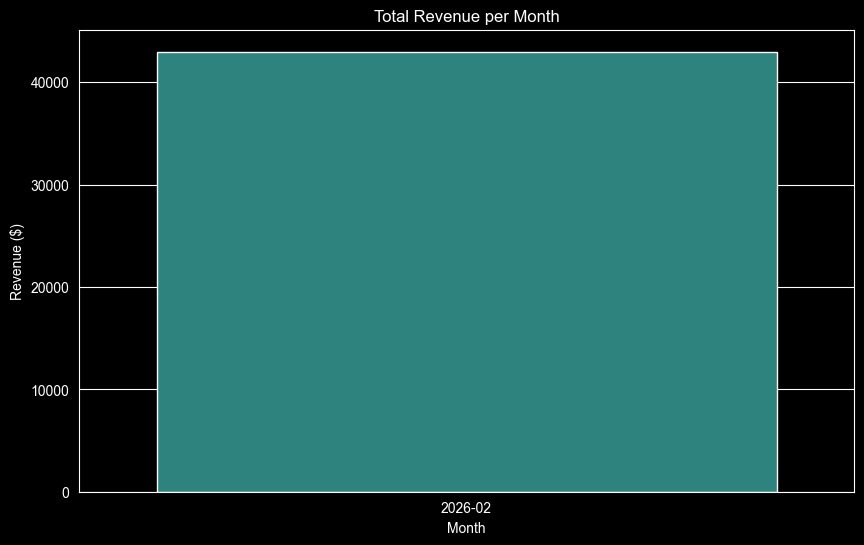

In [5]:
monthly_revenue = full_sales.groupby('month')['subtotal'].agg(np.sum).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=monthly_revenue, x='month', y='subtotal', hue='month', palette='viridis', legend=False)
plt.title('Total Revenue per Month')
plt.xlabel('Month')
plt.ylabel('Revenue ($)')
plt.show()

### 3. Best Selling Products

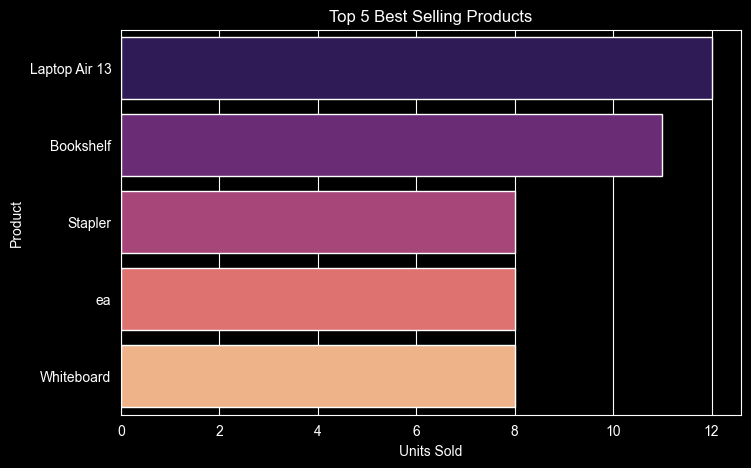

In [6]:
best_sellers = sales.groupby('name')['quantity'].agg(np.sum).sort_values(ascending=False).head(5).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=best_sellers, x='quantity', y='name', hue='name', palette='magma', legend=False)
plt.title('Top 5 Best Selling Products')
plt.xlabel('Units Sold')
plt.ylabel('Product')
plt.show()

### 4. Average Order Value Distribution 

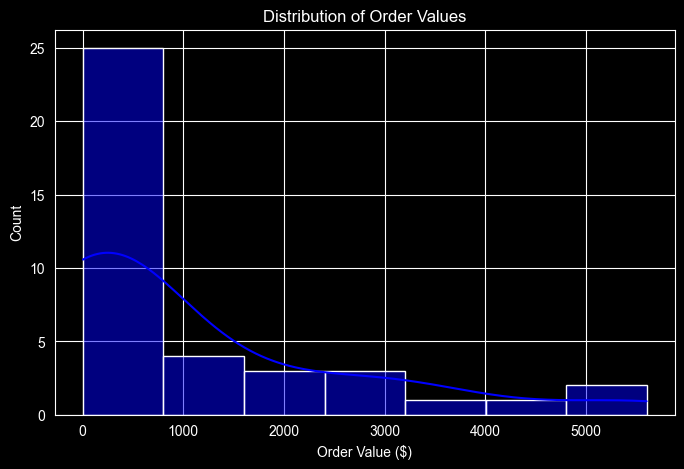

Mean Order Value: $1101.76


In [7]:
order_values = sales.groupby('order_id')['subtotal'].agg(np.sum)

plt.figure(figsize=(8, 5))
sns.histplot(order_values, kde=True, color='blue')
plt.title('Distribution of Order Values')
plt.xlabel('Order Value ($)')
plt.show()

print(f"Mean Order Value: ${np.mean(order_values):.2f}")

### 5. Customer Purchase Frequency


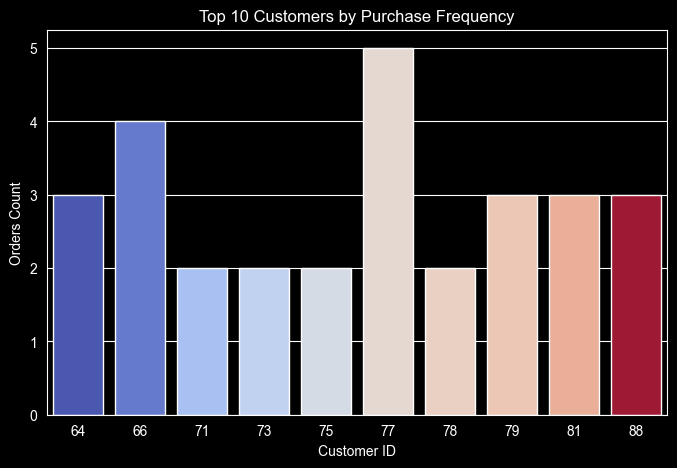

In [8]:
customer_freq = df_orders['customer_id'].value_counts().head(10).reset_index()
customer_freq.columns = ['customer_id', 'frequency']

plt.figure(figsize=(8, 5))
sns.barplot(data=customer_freq, x='customer_id', y='frequency', hue='customer_id', palette='coolwarm', legend=False)
plt.title('Top 10 Customers by Purchase Frequency')
plt.xlabel('Customer ID')
plt.ylabel('Orders Count')
plt.show()